# Imports / Resources

In [ ]:
# this is the source for the database.
# URL = 'https://www.kaggle.com/datasets/alessiocorrado99/animals10'

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from glob import glob
import random
import os
import cv2
from pathlib import Path
from keras.applications.vgg16 import preprocess_input
from google.colab import files
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import VGG16

In [ ]:
# muonting to google drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/פרוייקט סיכום הנדסת תוכנה/"

Mounted at /content/drive


In [ ]:
# location for kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = path
# location for download
%cd /tmp/
!kaggle datasets download -d alessiocorrado99/animals10
!unzip -qq -o animals10


/tmp
100% 585M/586M [00:15<00:00, 40.1MB/s]
100% 586M/586M [00:15<00:00, 40.5MB/s]


In [ ]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
             'sheep': 'pecora', "dog": "cane", "horse": "cavallo", "elephant" : "elefante",
             "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto",
             "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

# Overlap Calculating Function


In [ ]:
# calculate intersection over union
def localization_iou(y_true, y_pred):

    y_true = y_true.copy() #make a copy
    y_pred = y_pred.copy()

    y_true[:,2] +=y_true[:,0] #calculate y-high coordinate
    y_true[:,3] +=y_true[:,1] #calculate x-high coordinate

    y_pred[:,2] +=y_pred[:,0] #calculate y-high coordinate
    y_pred[:,3] +=y_pred[:,1] #calculate x-high coordinate

    # Calculate the coordinates of the intersection rectangle
    x_min = np.max([y_true[:, 0], y_pred[:,0]], axis=0)
    y_min = np.max([y_true[:, 1], y_pred[:, 1]], axis=0)
    x_max = np.min([y_true[:, 2], y_pred[:, 2]], axis=0)
    y_max = np.min([y_true[:, 3], y_pred[:, 3]], axis=0)

    # Calculate the area of intersection rectangle
    a = x_max - x_min
    b = y_max - y_min

    a = a * (a >= 0)
    b = b * (b >= 0)

    intersection_area = a * b

    # Calculate the area of the union rectangle
    y_true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    y_pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    union_area = y_true_area + y_pred_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


# Loading and Preparing Data

In [ ]:
data_dir = '/tmp/raw-img/'
dir_names = os.listdir(data_dir)
print(len(dir_names))
print(dir_names)


10
['cane', 'gallina', 'elefante', 'cavallo', 'scoiattolo', 'pecora', 'ragno', 'farfalla', 'gatto', 'mucca']


In [ ]:

def resize_images(input_folder, output_folder, new_size=(250, 250)):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Check if the file is an image
        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            try:
                # Open the image
                with Image.open(input_path) as img:
                    # Resize the image
                    resized_img = img.resize(new_size)

                    # Save the resized image to the output folder
                    output_path = os.path.join(output_folder, filename)
                    resized_img.save(output_path)

                    # print(f"Resized {filename} successfully.")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")



In [ ]:
# removing the classes "spider" and "butterfly" which I don't want to train on
shutil.rmtree(f"{data_dir}ragno")
shutil.rmtree(f"{data_dir}farfalla")

dir_names = os.listdir(data_dir)
print(len(dir_names))
print(dir_names)

8
['cane', 'gallina', 'elefante', 'cavallo', 'scoiattolo', 'pecora', 'gatto', 'mucca']


In [ ]:
animals = [translate[an] for an in dir_names]

animals

['dog', 'chicken', 'elephant', 'horse', 'squirrel', 'sheep', 'cat', 'cow']

In [ ]:
# normalize all the images to a smaller shape
# and put them in a new directory in the tmp server

input_dir = r'/tmp/raw-img/'

output_dir = r'/tmp/new/'


for animal in animals:
  resize_images(input_dir + translate[animal], output_dir + animal)
  print(f"done with {animal}")



done with dog
done with chicken
done with elephant
done with horse
done with squirrel
done with sheep
done with cat
done with cow


In [ ]:
# takes a folder path and loads all the images in the given path to a numpy array


def load_images_to_array(folder_path):
    # List to store images
    images = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Open the image file
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)

            # Convert image to numpy array
            img_array = np.array(img)

            # Append image array to the list
            # some images are shape (250, 250) which causes problems
            if img_array.shape == (250, 250, 3):
              images.append(img_array)

    # Convert the list of images into a numpy array
    images_array = np.array(images)

    return images_array



In [ ]:
# create the start of the array with the first animal

folder_path = output_dir + animals[0]
images_array = load_images_to_array(folder_path)
cat_array = np.array([0 for i in range(images_array.shape[0])])
print("Images array shape:", images_array.shape)
print(f"done with {animals[0]}")



Images array shape: (4863, 250, 250, 3)
done with dog


In [ ]:
# adding all the other images to the numpy array

cat_eng = {0: animals[0], animals[0] : 0}
animals.pop(0)

for idx, animal in enumerate(animals):

  # builds the dictionary
  cat_eng[animal] = idx+1
  cat_eng[idx+1] = animal

  new_arr = load_images_to_array(output_dir + animal)
  images_array = np.concatenate((images_array, new_arr), axis=0)

  cat_array = np.concatenate((cat_array, np.array([idx+1 for _ in range(new_arr.shape[0])])))

  print(f"done with {animal}, IDX: {idx+1}")
  print(images_array.shape)
  print(cat_array.shape, cat_array[cat_array.shape[0] -1])
  print()

done with chicken, IDX: 1
(7961, 250, 250, 3)
(7961,) 1

done with elephant, IDX: 2
(9397, 250, 250, 3)
(9397,) 2

done with horse, IDX: 3
(12020, 250, 250, 3)
(12020,) 3

done with squirrel, IDX: 4
(13882, 250, 250, 3)
(13882,) 4

done with sheep, IDX: 5
(15702, 250, 250, 3)
(15702,) 5

done with cat, IDX: 6
(17369, 250, 250, 3)
(17369,) 6

done with cow, IDX: 7
(19235, 250, 250, 3)
(19235,) 7



# Generators

(One generator for the train and another for the test)

In [ ]:
batch_size = 32
steps_per_epoch = 60 #how many batches per epoch
epochs = 10
animal_size = (250, 250, 3)


In [ ]:
# backgrounds
!wget -q 'https://raw.githubusercontent.com/arielb30/pokemon/main/backgrounds.zip'
!unzip -q -n backgrounds.zip

In [ ]:
backgrounds = []
background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # open and resize backgrounds
  bg = Image.open(f).resize((224, 224))  # images are originally shaped 224 by 350 ish
  backgrounds.append(np.array(bg))

In [ ]:
for bg in backgrounds:
  print(bg.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
# important for later when we save the model and run it on another notebook
# we wanna be able to tell which number predicted by the model corresponds
# to which of the classes we want to predict


for key in cat_eng.keys():
  if type(key) == str:
    print(key, cat_eng[key])

dog 0
chicken 1
elephant 2
horse 3
squirrel 4
sheep 5
cat 6
cow 7


In [ ]:

x_train, x_test, y_train, y_test = train_test_split(images_array, cat_array, test_size=0.15)


print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)


x_train (16349, 250, 250, 3)
x_test (2886, 250, 250, 3)
y_train (16349,)
y_test (2886,)


In [ ]:
# this is the generator
import random

def train_generator():
  # generate image and targets
  while True:
    for _ in range(steps_per_epoch):
      X = np.zeros((batch_size, bg.shape[0], bg.shape[1], 3)) # the background
      Y_bbox = np.zeros((batch_size, 4))  # the location in 4 nums
      Y_cat = np.zeros((batch_size,),dtype=int)

      for i in range(batch_size):
        X[i] = random.choice(backgrounds) #random background


        # choose a random animal
        animal_idx = np.random.randint(x_train.shape[0])
        animal_category = y_train[animal_idx] # the category of the animal
        animal = x_train[animal_idx] # the data
        anh, anw = animal.shape[0], animal.shape[1] # animal height and width

        # resize the animal (should be between 75 by 75 to 125 by 125)
        scale = 0.3 + (np.random.random() * 0.2)  # random number between 0.3 and 0.5

        # updates the height and width according to scale
        new_height = int(anh * scale)
        new_width = int(anw * scale * random.uniform(0.8, 1.2))

        # resize the object that is being worked on
        an = Image.fromarray(animal, 'RGB')
        an = an.resize((new_width, new_height))
        an = np.array(an)

        # maybe flip
        if np.random.random() < 0.5:
          an = np.fliplr(an)

        # choose a random location for the animal on the background
        # we subtract height and width to make sure location is within
        # the background image
        row0 = np.random.randint(bg.shape[0] - new_height)
        col0 = np.random.randint(bg.shape[1] - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # put the animal in teh background
        X[i, row0:row1, col0:col1, :] = an

        # this is the boundaries of the aminal which is on the background
        Y_bbox[i,0] = row0/bg.shape[0]
        Y_bbox[i,1] = col0/bg.shape[0]
        Y_bbox[i,2] = (row1 - row0)/bg.shape[0]
        Y_bbox[i,3] = (col1 - col0)/bg.shape[0]

        Y_cat[i] = animal_category

      yield X, (Y_bbox,Y_cat)

In [ ]:
X, (Y_bbox, Y_cat) = next(train_generator())
print(X.shape,Y_bbox.shape,Y_cat.shape)

(32, 224, 224, 3) (32, 4) (32,)


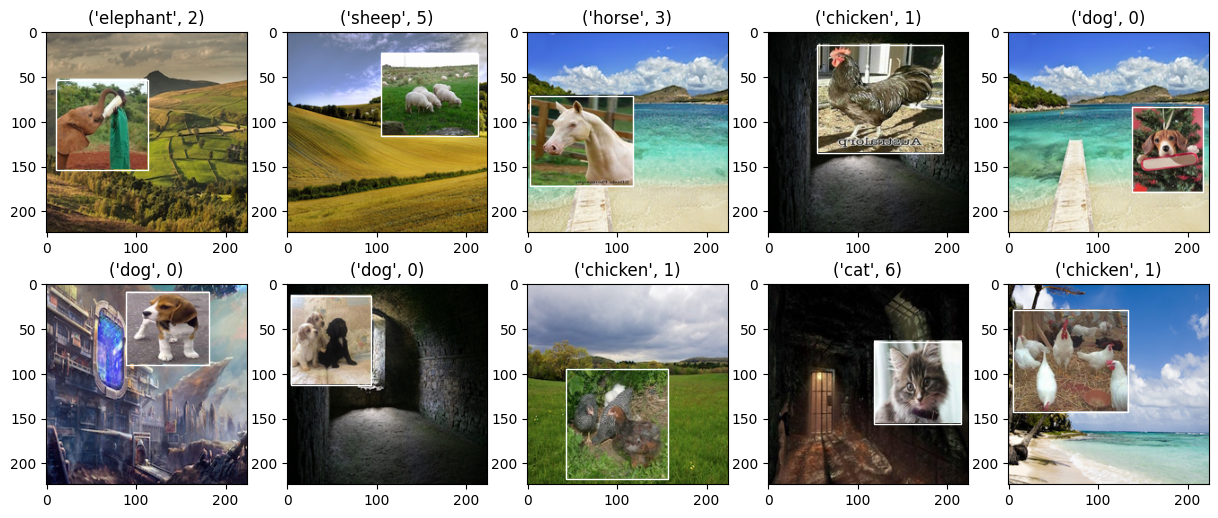

In [ ]:
sample = np.random.choice(np.arange(X.shape[0]), size=10, replace=False)
plt.figure(figsize=(15, 6)) #שטח התצוגה
for i, idx in enumerate(sample):
  x = X[idx]
  y_bbox = Y_bbox[idx]
  y_cat = Y_cat[idx]
  ax = plt.subplot(2, 5, i + 1)

  ax.imshow(x.astype(np.uint8))
  rect = Rectangle( #labels
    (y_bbox[1]*bg.shape[0], y_bbox[0]*bg.shape[0]),
    y_bbox[3]*bg.shape[0], y_bbox[2]*bg.shape[0],linewidth=1,edgecolor='w',facecolor='none')
  ax.add_patch(rect)
  plt.title(f"{cat_eng[y_cat], y_cat}",fontsize=12)

In [ ]:
# this is the generator
import random

def test_generator():
  # generate image and targets
  while True:
    for _ in range(steps_per_epoch):
      X = np.zeros((batch_size, bg.shape[0], bg.shape[1], 3)) # the background
      Y_bbox = np.zeros((batch_size, 4))  # the location in 4 nums
      Y_cat = np.zeros((batch_size,),dtype=int)

      for i in range(batch_size):
        X[i] = random.choice(backgrounds) #random background


        # choose a random animal
        animal_idx = np.random.randint(x_test.shape[0])
        animal_category = y_test[animal_idx] # the category of the animal
        animal = x_test[animal_idx] # the data
        anh, anw = animal.shape[0], animal.shape[1] # animal height and width

        # resize the animal (should be between 75 by 75 to 125 by 125)
        scale = 0.3 + (np.random.random() * 0.2)  # random number between 0.3 and 0.5

        # updates the height and width according to scale
        new_height = int(anh * scale)
        new_width = int(anw * scale * random.uniform(0.8, 1.2))

        # resize the object that is being worked on
        an = Image.fromarray(animal, 'RGB')
        an = an.resize((new_width, new_height))
        an = np.array(an)

        # maybe flip
        if np.random.random() < 0.5:
          an = np.fliplr(an)

        # choose a random location for the animal on the background
        # we subtract height and width to make sure location is within
        # the background image
        row0 = np.random.randint(bg.shape[0] - new_height)
        col0 = np.random.randint(bg.shape[1] - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # put the animal in teh background
        X[i, row0:row1, col0:col1, :] = an

        # this is the boundaries of the aminal which is on the background
        Y_bbox[i,0] = row0/bg.shape[0]
        Y_bbox[i,1] = col0/bg.shape[0]
        Y_bbox[i,2] = (row1 - row0)/bg.shape[0]
        Y_bbox[i,3] = (col1 - col0)/bg.shape[0]

        Y_cat[i] = animal_category

      yield X, (Y_bbox,Y_cat)

In [ ]:
X, (Y_bbox, Y_cat) = next(test_generator())
print(X.shape,Y_bbox.shape,Y_cat.shape)

(32, 224, 224, 3) (32, 4) (32,)


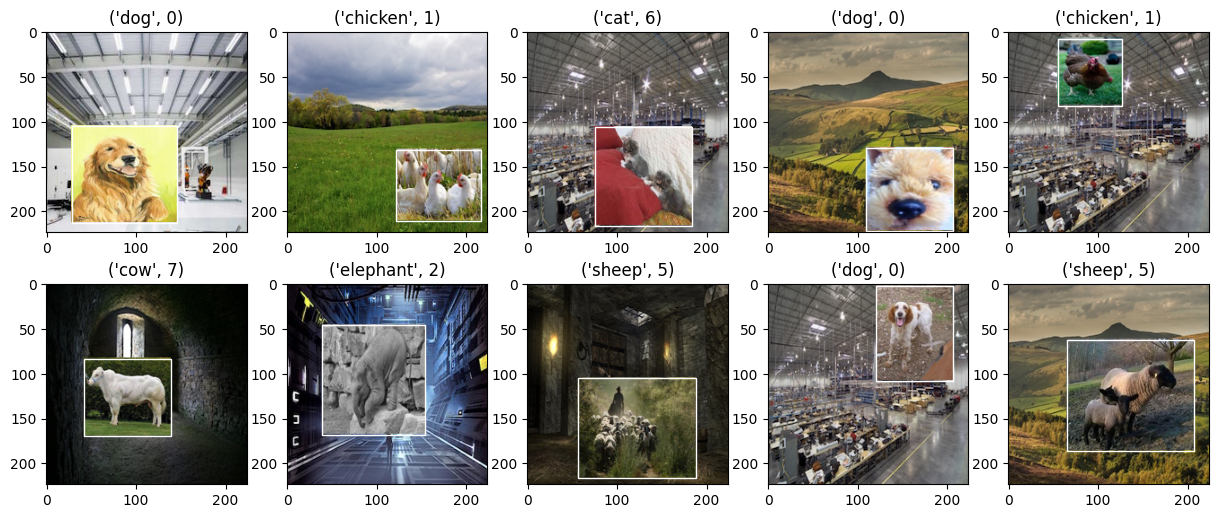

In [ ]:
sample = np.random.choice(np.arange(X.shape[0]), size=10, replace=False)
plt.figure(figsize=(15, 6)) #שטח התצוגה
for i, idx in enumerate(sample):
  x = X[idx]
  y_bbox = Y_bbox[idx]
  y_cat = Y_cat[idx]
  ax = plt.subplot(2, 5, i + 1)

  ax.imshow(x.astype(np.uint8))
  rect = Rectangle( #labels
    (y_bbox[1]*bg.shape[0], y_bbox[0]*bg.shape[0]),
    y_bbox[3]*bg.shape[0], y_bbox[2]*bg.shape[0],linewidth=1,edgecolor='w',facecolor='none')
  ax.add_patch(rect)
  plt.title(f"{cat_eng[y_cat], y_cat}",fontsize=12)

# Network

In [ ]:
vgg = tf.keras.applications.VGG16(
    input_shape=(bg.shape[0], bg.shape[1], 3),
    include_top=False,
    weights='imagenet')


vgg.summary()




58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def make_model():
  inputs = Input(shape=(bg.shape[0], bg.shape[1], 3))
  x = preprocess_input(inputs)
  x = vgg(x) #VGG feature extractor
  x = Flatten()(x) #prepare for dense
  x = Dense(32, activation='relu')(x) #dense with relu
  bbox_output = Dense(4,activation='sigmoid', name = 'bbox')(x) #Dense with sigmoid
  cat_output = Dense(8,activation='softmax',name = 'cat')(x) #Dense with softmax
  model = Model(inputs, outputs = [bbox_output, cat_output]) #create model
  return model

In [ ]:
model=make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                              

In [ ]:
LossFunc    =     {'bbox':'binary_crossentropy', 'cat':'sparse_categorical_crossentropy', }
lossWeights =     {'bbox':25.0, 'cat':1.0, }

model.compile(optimizer=Adam(learning_rate=1e-4),#adam
              loss=LossFunc,
              loss_weights=lossWeights,
              metrics = {'cat' : 'accuracy'}) #add accuracy metrics

In [ ]:
# validation is constant since the model did not like it when I had
# the validation data as an independant generator
batch_size = 256

X, (Y_bbox, Y_cat) = next(test_generator())
print(X.shape,Y_bbox.shape,Y_cat.shape)

(256, 224, 224, 3) (256, 4) (256,)


In [ ]:
batch_size = 32

history = model.fit(
    train_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(X, (Y_bbox, Y_cat))
)

Epoch 1/50
60/60 [==============================] - 22s 143ms/step - loss: 20.5338 - bbox_loss: 0.7285 - cat_loss: 2.3208 - cat_accuracy: 0.1750 - val_loss: 17.7333 - val_bbox_loss: 0.6276 - val_cat_loss: 2.0431 - val_cat_accuracy: 0.2070
Epoch 2/50
60/60 [==============================] - 8s 130ms/step - loss: 17.4128 - bbox_loss: 0.6140 - cat_loss: 2.0630 - cat_accuracy: 0.2167 - val_loss: 17.4904 - val_bbox_loss: 0.6188 - val_cat_loss: 2.0203 - val_cat_accuracy: 0.2148
Epoch 3/50
60/60 [==============================] - 8s 130ms/step - loss: 17.2968 - bbox_loss: 0.6102 - cat_loss: 2.0410 - cat_accuracy: 0.2193 - val_loss: 17.3873 - val_bbox_loss: 0.6152 - val_cat_loss: 2.0084 - val_cat_accuracy: 0.2617
Epoch 4/50
60/60 [==============================] - 8s 130ms/step - loss: 17.1156 - bbox_loss: 0.6038 - cat_loss: 2.0199 - cat_accuracy: 0.2495 - val_loss: 17.3356 - val_bbox_loss: 0.6129 - val_cat_loss: 2.0121 - val_cat_accuracy: 0.2578
Epoch 5/50
60/60 [=============================

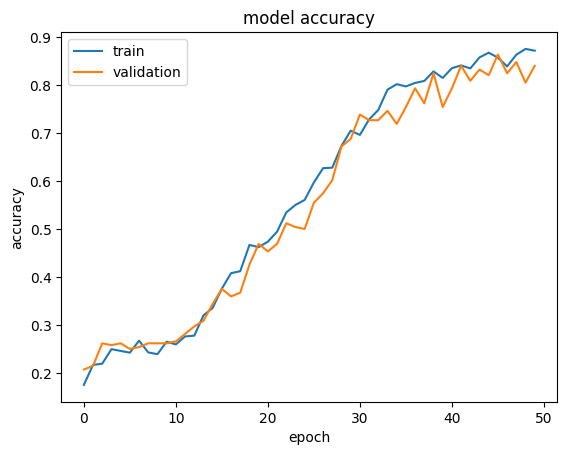

In [ ]:
plt.plot(history.history['cat_accuracy'])
plt.plot(history.history['val_cat_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


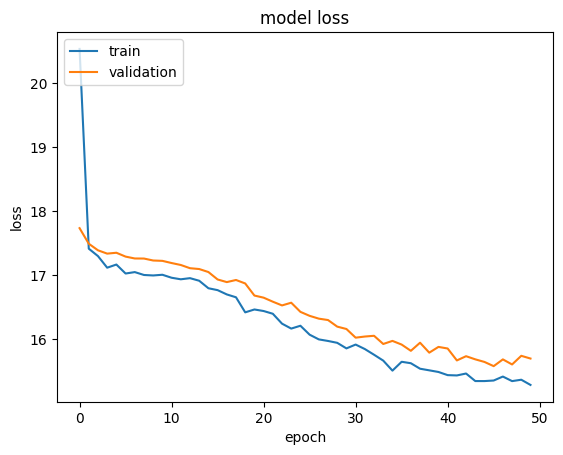

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

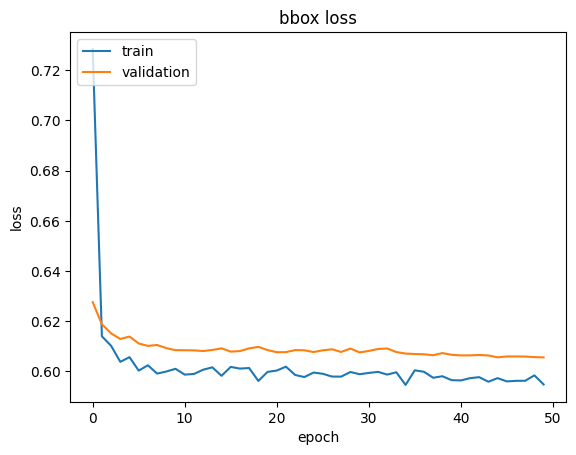

In [ ]:
plt.plot(history.history['bbox_loss'])
plt.plot(history.history['val_bbox_loss'])
plt.title('bbox loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# makes the test batch
batch_size = 256

X, (Y_bbox, Y_cat) = next(test_generator())
print(X.shape,Y_bbox.shape,Y_cat.shape)

(256, 224, 224, 3) (256, 4) (256,)


In [ ]:
(pred_bbox,pred_cat) = model.predict(X) #predict on X
print(pred_bbox.shape,pred_cat.shape)

8/8 [==============================] - 1s 36ms/step
(256, 4) (256, 8)


In [ ]:
# average IOU for all examples
iou = localization_iou(y_true=Y_bbox,y_pred=pred_bbox)
np.mean(iou)

0.8167235979328729

In [ ]:
print(pred_cat[0])
print(np.argmax(pred_cat[0]))
print(Y_cat[0])

[3.1780086e-03 4.0581640e-02 7.1302749e-04 9.8545644e-03 1.7249385e-04
 9.3458021e-01 3.1543643e-06 1.0916913e-02]
5
5


In [ ]:
p_cat = []

for i in range(Y_cat.shape[0]):
  p_cat.append(np.argmax(pred_cat[i]))

print(len(p_cat))

256


In [ ]:
tot = 0
for i in range(len(p_cat)):
  if p_cat[i] == Y_cat[i]:
    tot += 1

print("test accuracy:" , tot / len(p_cat))


test accuracy: 0.86328125


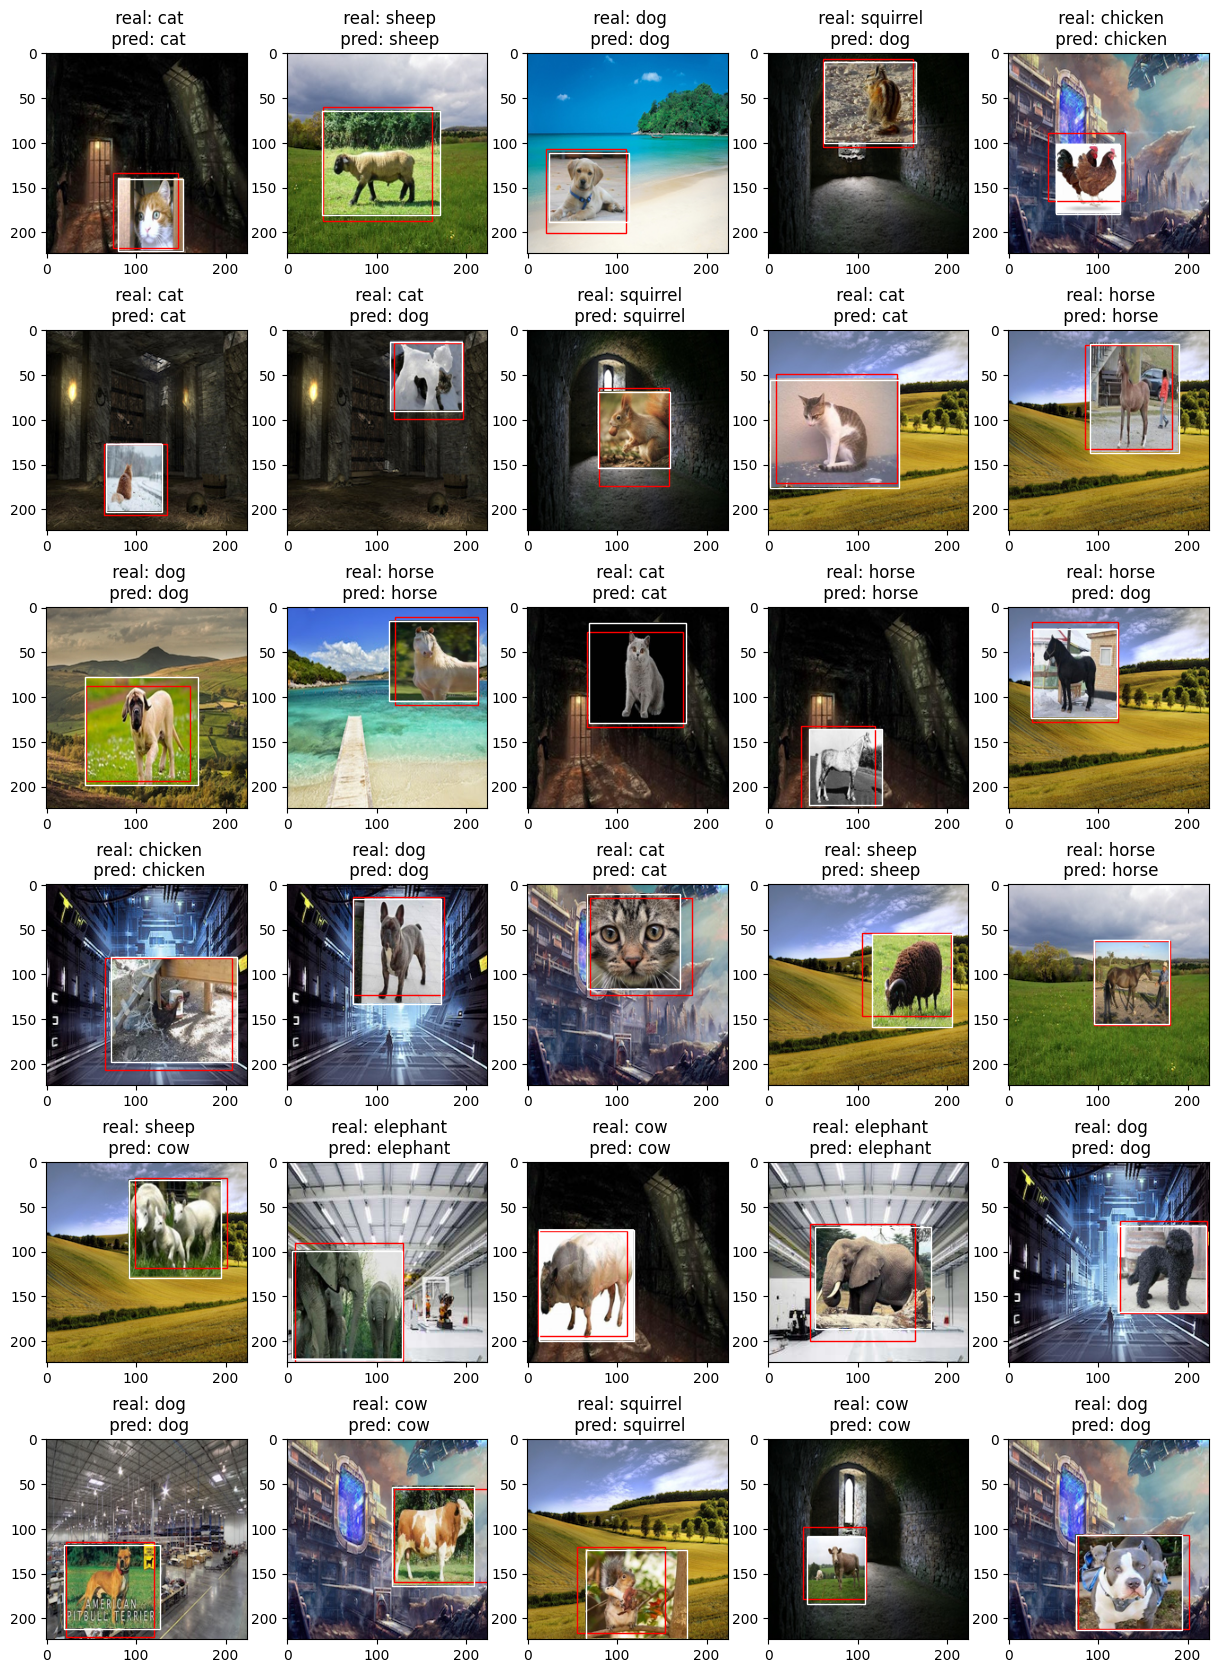

In [ ]:
sample = np.random.choice(np.arange(X.shape[0]), size=30, replace=False)
plt.figure(figsize=(15, 21)) #שטח התצוגה
for i, idx in enumerate(sample):
  x = X[idx]
  y_cat = Y_cat[idx]
  y_bbox = Y_bbox[idx]

  p_cat = np.argmax(pred_cat[idx])
  p_bbox = pred_bbox[idx]
  ax = plt.subplot(6, 5, i + 1)

  # Draw the box
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle( #predictions
    (p_bbox[1]*bg.shape[0], p_bbox[0]*bg.shape[0]),
    p_bbox[3]*bg.shape[0], p_bbox[2]*bg.shape[0],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

  rect = Rectangle( #labels
    (y_bbox[1]*bg.shape[0], y_bbox[0]*bg.shape[0]),
    y_bbox[3]*bg.shape[0], y_bbox[2]*bg.shape[0],linewidth=1,edgecolor='w',facecolor='none')
  ax.add_patch(rect)

  plt.title(f" real: {cat_eng[y_cat]}\n pred: {cat_eng[p_cat]}",fontsize=12)

In [ ]:
from tensorflow import keras

keras.saving.save_model(model, "/content/drive/MyDrive/פרוייקט סיכום הנדסת תוכנה/sexy_model.keras", overwrite=True, save_format="tf")

In [ ]:
eval = model.evaluate(X, (Y_bbox, Y_cat))

8/8 [==============================] - 0s 41ms/step - loss: 15.4646 - bbox_loss: 0.6030 - cat_loss: 0.3902 - cat_accuracy: 0.8633
